## Time Series Forecasting using the Holt-Winters Model
John Lochner, Tulane University, PHYS 3530


# Motivation
Time series data forecasting is a vital tool for businesses and organizations across a range of industries, enabling them to plan, allocate resources, manage risk, and make informed decisions based on predicted trends. By analyzing historical data and identifying patterns, time series forecasting provides valuable insights into future trends and behaviors, helping businesses to optimize their operations, improve their performance, and stay ahead of the competition. 

 \
From financial forecasting and supply chain management to marketing and risk management, time series forecasting plays a critical role in modern business strategy, providing a powerful tool for organizations to anticipate changes, mitigate risks, and seize new opportunities.
 \

![weather](https://media.wwltv.com/assets/WWL/images/bbc18567-b544-4de5-972e-15067736ba39/bbc18567-b544-4de5-972e-15067736ba39_360x203.png)

 \
New Orleans has some of the most irratic weather in the United States, and can make weather forecasting very difficult. Traditional techniqes involve complex differential equations that have hundreds of variables and have extremly unstable solutions that require complex numerical solving techniques.
 \
 \
Instead of solving these traditionally, we will instead use a couple forms of data forecasting using historical metadata provided by Iowa State University's Environmental Mesonet. 

<img src="https://mesonet.agron.iastate.edu/images/logo_large.png"
     style="float: center; margin-right: 10px;" />

# Introduction
We will begin by importing out data from the downloaded .CSV file using the XLSX package.


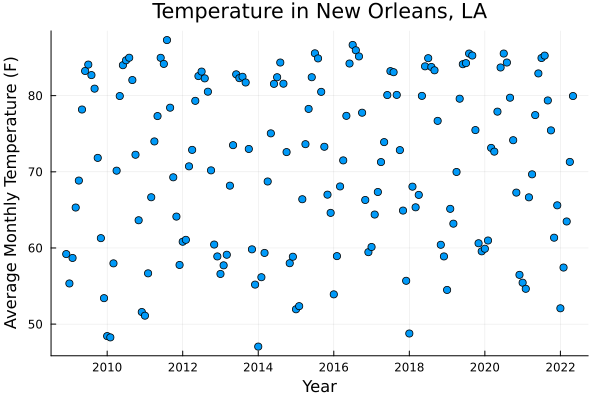

In [1]:
using Plots, Optim, DataFrames
import XLSX

# read data from Excel file

dtable = XLSX.readtable("30_temp.xlsx","30_temp",)
m = hcat(dtable.data...)
# data function will see
data=m[1:162,2]
time=collect(2008+11/12:1/12:2022+4/12)
# hidden data for comparison (future data)
real_new_data=m[162:end,2]
time2=collect(2022+4/12:1/12:2023+4/12)

# Plot orginial data (this is what the function will see)
scatter(time, data, xlabel="Year", ylabel="Average Monthly Temperature (F)", legend=false,title="Temperature in New Orleans, LA")

The simplest approach to predicting the next value in this time series is to simply ignore the previous values and assume the next value will be the same as the last value in the time series:
$$ y_{T+1}=y_T$$
Another school of thought may be to assume the next point is an average of all previous values:
$$ Y_{T+1}=\frac{1}{T}\sum^{T}_{t=1}y_t $$
Now at this point, one may grasp that both of these assumptions are polar extremes of the same technique of assigning weights to each previous value.\
\
In the first method, we assume weights for all previous values are 0, except for the last value, which has a weight of 1.
In the second method, we assume equal weights of 1 for all previous values. 
\
\
Now one may grasp that the optimal solution involves different wieghts for each value, but how is this achieved?


## Exponential Smoothing

If we assume older data is less "relevant", we can assign lower weight to that data. Mathematically, this can take the form of an exponential decrease in weight the older data is.

$$Y_{T+1}=\alpha * Y_T+\alpha(1-\alpha)*Y_{T-1}+\alpha(1-\alpha)^2... +\alpha(1-\alpha)^{T-1}*y_1$$
This becomes,
$$\rightarrow \space Y_{T+1}=\sum^{T-1}_{i=0}\alpha(1-\alpha)^j * Y_{T-i}$$
In this equation $\alpha$ is known as the smoothing constant and has domain $ 0 \geq \alpha \geq 1 $. It quantifies the level of decay occuring to the weights. 
\
\
The Simple Exponential Smoothing (SES) method is essentially just a weighted average across all time steps, with the weights exponentially decaying. Hence the name: simple exponential smoothing.
\
\
Unfortunately, this is not a very functional form, but this can be fixed.

If we instead consider the initial level or estimate as represented by the following,
$$\rightarrow \space y_{1|0}=l_0$$ 
This can be generalized to the level at $h$ predictions into the future,
$$\rightarrow \space y_{t+h|t}=l_t$$
which gives the new simple exponential smoothing function in component form.
$$l_t=\alpha*y_t+(1-\alpha)*l_{t-1}$$
This is also known as the level update equation, because it updates the level of the current time step from the previous level estimation. 

## Holts Exponential Smoothing Method
Many data sets follow some sort of trend. At present, our derived SES function lacks the ability to predict different values farther into the future. 
\
\
Holts Exponential Smoothing Method takes an additional trend parameter, which is wieghed by $\beta$.
$$ l_t=\alpha+(1-\alpha)(l_{t-1}+T_{t-1})$$
The slope (trend) eqaution $T_t$ is
$$ T_t=\beta(l_t-l_{t-1})+(1-\beta)T_{t-1}$$

The $\beta$ parameter determines how quickly the trend component can change over time. A smaller value of beta puts more weight on past trend values, resulting in a smoother trend line, while a larger value of beta puts less weight on past trend values, resulting in a more responsive trend line.


## Winters' Exponential Smoothing Method


Winter's exponential smoothing method, also known as triple exponential smoothing, is an extension of Holt's exponential smoothing method that incorporates seasonality into the forecast. This method is useful for forecasting time series data with a repeating pattern.

The method uses three smoothing parameters: alpha (α) for the level component, beta (β) for the trend component, and gamma (γ) for the seasonal component. The level equation for Winter's method is similar to that of Holt's method:

\begin{equation}
l_t = \alpha (y_{t} - s_{t-m}) + (1 - \alpha)(l_{t-1} + T_{t-1}),
\end{equation}

where:

- $y_{t}$ is the actual value at time period $t$.
- $s_{t-m}$ is the seasonal component for the current time period $t$.
- $m$ is the seasonality parameter

The trend equation is also similar to that of Holt's method:

\begin{equation}
T_{t} = \beta(l_{t} - l_{t-1}) + (1 - \beta)T_{t-1}.
\end{equation}

The seasonal equation is slightly different:

\begin{equation}
s_{t} = \gamma(y_{t} - l_{t-1} - T_{t-1}) + (1 - \gamma)s_{t-m}.
\end{equation}

Here, we see that the seasonal component is calculated as the difference between the actual value at time $t$ and the level and trend components, and then smoothed using the seasonal factor.

Winter's exponential smoothing method is an extension of Holt's method that incorporates seasonality into the forecast by using three smoothing parameters for the level, trend, and seasonal components. The method is useful for forecasting time series data with a repeating pattern.



It is important to note that the seasonality $m$ must be known ahead of time. This is fairly easy for our data, as it has clear yearly cycles which contain 12 months. Thus $m=12$

## Holt-Winters Prediction Function

In [7]:
## Generates forecast using Holt-Winters additive model for n prediction cycles
# note that the variables l0, T0, s0 are all initial values for the zeroth cycle. 
#n_pred = number of desired predictions (cycles)
function HW_Seasonal_forecast(data, α, β, γ, l0, T0, s0, m, n_pred)
    N = length(data)
    l_t = 0
    T_t = 0
    l_t_ = 0 #Variable to save l(t-1)
    T_t_ = 0 #Variable to save b(t-1)
    s_ = 0
    s = s0 
    
    pred = []

    for i in 0:(N - 1)
        if i == 0
            l_t = l0
            T_t =T0
        else
            l_t = (data[i] - s_) * α + (l_t_ + T_t_) * (1 - α) 
            T_t = β * (l_t - l_t_) + (1 - β) * T_t_
        end
        l_t_ = l_t
        T_t_ = T_t
        s_ = s[i%m + 1]
        
        y_pred = l_t + T_t + s[i%m + 1]
        
        push!(pred, y_pred)
        
        s[i%m + 1] = γ * (data[i + 1] - l_t_ - T_t_) + (1 - γ) * s[i%m + 1]   
    end
    
    l_t = (data[end] - s_) * α + (l_t + T_t) * (1 - α)
    T_t = β * (l_t - l_t_) + (1 - β) * T_t_
    
    for i in N:(N+n_pred - 1)
        y_pred = l_t + T_t*(i-N+1) + s[i%m + 1] 
        #The trend has to be added as many times as periods we want to forecast.
        push!(pred, y_pred)
    end 
    
    return pred
end


HW_Seasonal_forecast (generic function with 1 method)

# But wait! What are the Parameters???
As one might have noticed, this function is useless without given input parameters $α, β, γ, l_0, T_0, s_0$.

One way to qauntify the accuracy of this function using a given set of parameters is to subtract predicted values from known values. This is known as a loss function.\
 \
The Squared Error loss function is used to measure the degree of error between the predicted and actual values of a time series. Squaring the difference ensures that the loss function is always positive and that larger errors are more heavily penalized. The Squared Error loss function is commonly used in machine learning algorithms for regression tasks.

\begin{equation}
SE = \sum_{t=1}^{n}(y_{t} - \hat{y}_{t})^2,
\end{equation}

where:

-$n$ is the number of time periods in the time series.\
-$y_{t}$ is the actual value at time period $t$.\
-$\hat{y}_{t}$ is the predicted value at time period $t$.



## Loss Function 

In [13]:
# Loss function for Holt-Winters (additive method) (seasonality of m=12)

function HW_loss(time_serie, α, β, γ, T0, l0, s01,s02,s03,s04,s05,s06,s07,s08,s09,s10,s11,s12)
    s0=[s01,s02,s03,s04,s05,s06,s07,s08,s09,s10,s11,s12]
    m=12
    N = length(time_serie)
    l_t = 0
    T_t = 0
    l_t_ = 0 #Variable to save l(t-1)
    T_t_ = 0 #Variable to save b(t-1)
    s_ = 0
    s = s0
    loss=0
    y_pred=0

    for i in 0:(N - 1)
        if i == 0
            l_t = l0
            T_t = T0
        else
            l_t = (time_serie[i] - s_) * α + (l_t_ + T_t_) * (1 - α) 
            T_t = β * (l_t - l_t_) + (1 - β) * T_t_
        end
        l_t_ = l_t
        T_t_ = T_t
        s_ = s[i%m + 1]
        y_pred = l_t + T_t + s[i%m + 1]
        loss += (time_serie[i+1] - y_pred)^2
        s[i%m + 1] = γ * (time_serie[i + 1] - l_t_ - T_t_) + (1 - γ) * s[i%m + 1]
    end
  return loss
end



HW_loss (generic function with 1 method)

## Optimization
The output of this function is a single loss total for the function given certain parameters. Trying different parameters yeilds different loss values, which tell us about the accuracy of those parameters. Trying at random can take eternity and absurd computing time.
 \
 \
<img src="https://florarblog.files.wordpress.com/2018/08/optimization_path2.gif" alt="graph" title="Optimization" width="500" height="300" />
      \
       \
Instead, these parameters can be optimized using a variety of complex mathemetical techniques. Thankfully, the Optim.jl package contains a number of integrated optimzation algorithms. 



# Optim.jl
Optim.jl is a Julia library that provides a flexible and efficient optimization infrastructure for various types of optimization problems, including unconstrained and constrained optimization. The library offers a range of algorithms for optimization, including the LBFGS optimizer. 

The Limited-memory Broyden-Fletcher-Goldfarb-Shanno (LBFGS) optimizer is a popular optimization algorithm used in machine learning and time series prediction. It is an iterative method that seeks to minimize the value of a given loss function. Here's how the LBFGS optimizer works:

### Step 1: Initialize the Parameters

The optimization process begins by initializing the model parameters with some initial values. These values can be randomly assigned or set to a default value. 

### Step 2: Compute the Gradient

The LBFGS optimizer computes the gradient of the loss function with respect to the model parameters. The gradient indicates the direction in which the loss function is decreasing most rapidly, and is used to update the model parameters in the next step. 

### Step 3: Update the Parameters

Using the gradient, the LBFGS optimizer updates the model parameters in a direction that reduces the value of the loss function. The update step can be expressed using the following equation:

$θ_{t+1} = θ_{t} - α_t * H_t^{-1} * g_t$


where:

- $θ_{t+1}$ is the updated set of model parameters at iteration t+1.
- $θ_t$ is the set of model parameters at iteration t.
- $α_t$ is the step size or learning rate at iteration t.
- $H_t^{-1}$ is an approximation of the inverse Hessian matrix at iteration t.
- $g_t$ is the gradient of the loss function with respect to the model parameters at iteration t.

The inverse Hessian matrix is an approximation of the second-order derivative of the loss function with respect to the model parameters. It is used to ensure that the update step is in the direction of the minimum of the loss function. The approximation is made using previous iterations of the optimizer, which is why the LBFGS optimizer is called a "limited-memory" optimizer. 

### Step 4: Repeat Until Convergence

The LBFGS optimizer repeats the gradient computation and parameter update steps until a stopping criterion is met. This can be a maximum number of iterations, a minimum improvement in the loss function value, or a maximum change in the model parameters.

Here is a visual representation of the LBFGS optimizer process:

![LBFGS Algorithm](https://miro.medium.com/v2/resize:fit:1400/1*47skUygd3tWf3yB9A10QHg.gif)

In summary, the LBFGS optimizer is an iterative algorithm that seeks to minimize the value of a given loss function. It updates the model parameters using the gradient of the loss function and an approximation of the inverse Hessian matrix. The LBFGS optimizer repeats this process until a stopping criterion is met, resulting in a set of optimized model parameters that minimize the loss function.

# Wrapping & Setting Bounds
A wrapper function is required to properly call the optimize function, which cannot optimize vectorized parameters. Thus, the 12-element seasonality parameter, $s$, is pulled out as individal parameters. 

In [4]:
# Wrapper function for loss function
function HW_loss_(params, time_serie=data)
    return HW_loss(time_serie, params[1], params[2], params[3],params[4],params[5],params[6],params[7],params[8],params[9],params[10],params[11],params[12],params[13],params[14],params[15],params[16],params[17])
  end

HW_loss_ (generic function with 2 methods)

In order to increase the efficiency of the optimazation algorithm, bounds can be set to eliminate known impossibilities. An easy example is the known range of $ 0 \geq \alpha, \beta, \gamma \geq 1 $. 

In [5]:
# Starting parameters and bounds
lower_ = [0,0,0,0,60,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100];
upper_ = [1,1,1,10,80,100,100,100,100,100, 100, 100, 100, 100, 100, 100, 100];
initial_x_ = [.5,.5,.5,2,65,0,0,0,0,0,0,0,0,0,0,0,0];

# Getting Parameters

In [6]:
# optimizes the loss function
res = optimize(HW_loss_, lower_, upper_, initial_x_);

# minimizes + prints parameters
res1=Optim.minimizer(res)

17-element Vector{Float64}:
   0.18567738816332058
   3.421778778378431e-19
   3.491506823502762e-19
   0.0043895897431073146
  70.12636091989722
 -12.085758441264163
 -16.315862316895952
 -11.714537621308017
  -5.128212924943551
   0.3673974854164716
   7.3587221809593695
  12.811732332750637
  13.993496589055226
  14.069876230346813
  11.122409717015792
   3.128020126849029
  -7.61483100062876

Now that we have obtained paramters, the forecast can be calculated using our old function. We will aim for a full year of data, or 12 months of predicted temperatures.

In [14]:
n_pred=12
season_forecast = HW_Seasonal_forecast(data,res1[1],res1[2],res1[3],res1[5],res1[4],res1[6:end], 12, n_pred);

# Results

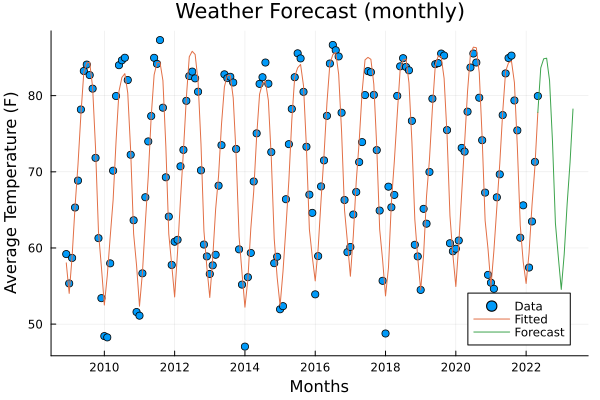

In [9]:
# Plot Forecast
pt1=scatter(time, data, label="Data", legend=:bottomright)
plot!(pt1,time, season_forecast[1:length(data)], label="Fitted")
plot!(pt1,time2, season_forecast[length(data):end], label="Forecast",title="Weather Forecast (monthly)",ylabel="Average Temperature (F)",xlabel="Months")

As shown, the seasonality of the data is well defined by the function. The predicted data (green) follows a similar, but unique pattern from previous yearly trends. The ability to average and weight past yearly seasonality is beyond the ability of most humans. 

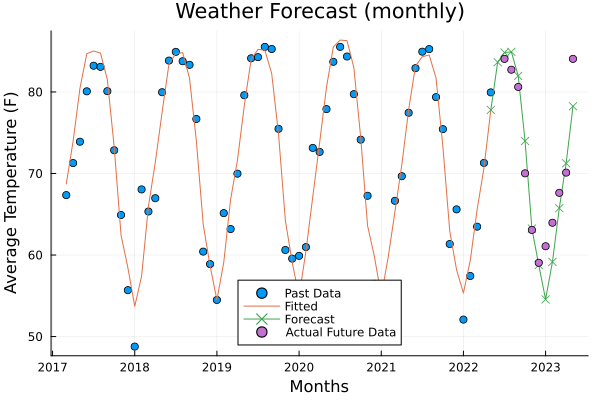

In [10]:
# Plot Forecast again
pt2=scatter(time[100:end], data[100:end], label="Past Data", legend=:bottom)
plot!(pt2,time[100:end], season_forecast[100:length(data)], label="Fitted")
plot!(pt2,time2, season_forecast[length(data):end], label="Forecast",title="Weather Forecast (monthly)",ylabel="Average Temperature (F)",xlabel="Months",markershape=:xcross)
scatter!(pt2,time2[3:end],real_new_data[3:end],label="Actual Future Data")

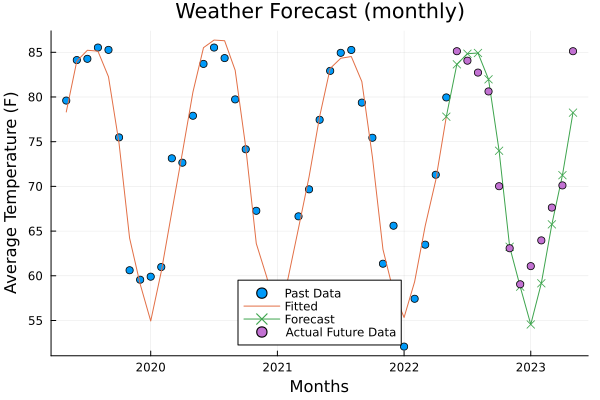

In [11]:
pt3=scatter(time[end-36:end], data[end-36:end], label="Past Data", legend=:bottom)
plot!(pt3,time[end - 36:end], season_forecast[length(data)-36:length(data)], label="Fitted")
plot!(pt3,time2, season_forecast[length(data):end], label="Forecast",markershape=:x,title="Weather Forecast (monthly)",ylabel="Average Temperature (F)",xlabel="Months")
scatter!(pt3,time2[2:end],real_new_data[2:end],label="Actual Future Data")